# TI3145TU Midterm Assignment 
## Football Players Wages

We hope you enjoy this assignment, good luck!

Student names: XXX

Student numbers: XXX

### Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

from itertools import product

### Load data

In [2]:
# These are your training samples along with their labels
data = pd.read_csv('football_wages.csv')
data.head()

# You need to extract the features and the regression target. The regression target is 'log_wages'.

,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,log_wages
0,27.0,183.0,76.0,b'Korea Republic',57.0,58.0,54.0,30.0,55.0,53.0,...,60.0,67.0,63.0,58.0,9.0,13.0,8.0,11.0,10.0,3.000000
1,21.0,182.0,70.0,b'France',61.0,72.0,58.0,63.0,46.0,62.0,...,47.0,65.0,31.0,33.0,9.0,11.0,9.0,12.0,11.0,3.000000
2,35.0,182.0,75.0,b'Korea Republic',68.0,68.0,62.0,68.0,68.0,70.0,...,61.0,69.0,36.0,40.0,8.0,12.0,7.0,12.0,6.0,3.301030
3,29.0,169.0,70.0,b'Paraguay',67.0,67.0,62.0,55.0,50.0,71.0,...,59.0,84.0,40.0,55.0,6.0,10.0,11.0,15.0,9.0,2.698970
4,30.0,176.0,74.0,b'Austria',65.0,65.0,63.0,49.0,53.0,63.0,...,58.0,75.0,65.0,64.0,12.0,15.0,10.0,8.0,10.0,3.477121


### Partition the data
Seperate the data and the label. Remove the nationality column, although this affect wages the amount of nations are large. This results in large sparse matrices when using one-hot-encoding which affects KNN performance.

In [3]:
SEED = 42
np.random.seed(SEED)


In [4]:
# Shuffle the dataset to make sure the distribution is random before dividing in training and testing data
df = data.sample(n=len(data), random_state=SEED)
# Delete the nationality column, although this affect wages the amount of nations is large, which results in when using
# one-hot-encoding nationality becoming very important to the classifier.
df = df.drop(columns=['nationality_name'])
labels = df.iloc[:,:-1].columns.tolist()
# extract training data and labels
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
# Partition the data
training_size = 4000
X_train = X.iloc[:training_size,:]
X_val = X.iloc[training_size:,:]
y_train = Y.iloc[:training_size].values
y_val = Y.iloc[training_size:].values

### Baseline
By predicting the median log-wage for every player, we can compute the baseline MAE on the validation folds. This gives us a direct reference point: any real regression model should produce a lower MAE than this trivial guess. Presenting this baseline is essential because it shows the absolute minimum standard of performance, making it immediately clear whether the trained models truly learn patterns in the data or merely approximate the central tendency.


In [5]:
# Baseline using median log-wage predictions
median_log_wage = np.median(y_train)
baseline_predictions = np.full_like(y_val, median_log_wage, dtype=float)
baseline_mae = mean_absolute_error(y_val, baseline_predictions)
print(f"Baseline (median) MAE: {baseline_mae:.4f}")


Baseline (median) MAE: 0.4849


### Inspect the data
Create a histogram to inspect the distribution of the data.

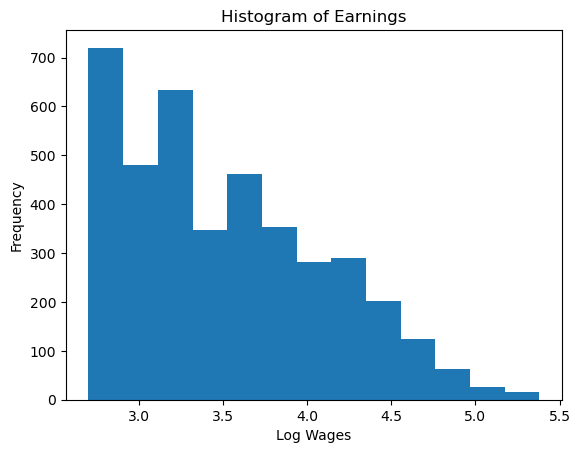

In [6]:
plt.figure()
plt.hist(y_train, bins=13)
plt.title('Histogram of Earnings')
plt.xlabel('Log Wages')
plt.ylabel('Frequency')
plt.show()

### Scale the data
Scale each column to 0 mean and 1 variance; if not the KNN algorithm would be too heavily weighing data that have a larger absolute difference between them. Since the data is heavily left-skewed, outliers were chosen to not be removed.

In [7]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train = pd.DataFrame(data=X_train, columns=labels)
X_val = pd.DataFrame(data=X_val, columns=labels)
X_train

,age,height_cm,weight_kg,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,movement_agility,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,-0.887690,-1.108107,-0.718351,-0.412965,0.627757,0.474668,0.916394,0.532880,-0.048122,0.644755,...,0.776655,-0.073649,0.845298,-1.530515,-1.132054,-0.263503,-0.200935,-0.608298,-0.604560,-0.318445
1,0.788878,0.660913,-0.292304,0.453546,-0.350121,-0.074065,1.367147,1.330348,0.222418,1.595433,...,0.108033,1.242487,-0.185469,-1.390340,-1.179958,-0.041208,-0.259161,-0.608298,-0.374574,-0.154185
2,0.998449,-0.076178,0.985838,0.742383,-0.024162,0.474668,1.116728,1.216424,0.560594,1.483589,...,0.442344,0.584419,1.188887,-0.969814,-0.748822,-0.541371,-0.608512,-0.018791,-0.489567,-0.154185
3,-0.468548,0.366077,0.559790,0.886801,0.790736,1.133148,1.266980,0.191108,0.560594,0.924366,...,0.375482,0.036029,-0.116752,-0.222213,-0.509303,-0.596945,-0.317386,-0.490397,-0.432071,-0.427951
4,0.788878,-0.223597,-0.008272,-0.701801,-1.653958,0.200301,0.315389,-0.264589,0.290053,0.476989,...,0.776655,-0.293005,0.982734,0.431938,0.496680,-0.096782,-0.142710,-0.608298,-0.489567,-0.099432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.468548,0.071240,0.985838,0.309128,0.627757,0.584415,-0.485949,0.646804,0.425324,-0.194078,...,0.174895,-0.183327,-1.284955,0.899189,1.215239,-0.485797,-0.375611,-0.372495,-0.317078,-0.099432
3996,-0.887690,0.808332,2.974058,-0.701801,-0.350121,-1.994632,-1.888293,-2.372184,-2.077178,-1.983589,...,-1.897835,-0.402683,-1.628544,-1.623966,-1.563190,2.237313,2.244525,2.810847,2.615236,2.638231
3997,2.046303,-0.223597,-0.718351,0.309128,-0.513101,0.364921,-0.736368,1.273386,-0.183393,-0.809223,...,-0.226279,0.694097,-0.116752,1.086090,1.167335,-0.152355,-0.608512,-0.136692,-0.547063,-0.318445
3998,0.579307,0.955750,2.832042,0.597965,-0.187141,-2.049505,-1.537707,-2.030412,-2.415354,-1.480289,...,-1.764110,-0.183327,-1.284955,-1.437065,-1.419478,2.959771,2.710327,3.105601,3.190200,3.131011


### Pipeline 1
Create a random forest regressor to get an indication of what features are considered important for the tree classifier. And select the most important for testing of the kNN model.

In [8]:
# Create a random forrest classifier
forest = RandomForestRegressor(random_state=SEED)
forest.fit(X_train, y_train)
importance = forest.feature_importances_

# Create a dataframe to use when plotting result
importance_df = pd.DataFrame({'Labels': labels,
                   'Importance Coefficient': importance})
importance = importance_df.sort_values(by=['Importance Coefficient'], ascending=False)
print(importance)

                        Labels  Importance Coefficient
3                      overall                0.662768
0                          age                0.028682
4                    potential                0.015850
18          movement_reactions                0.015021
7   attacking_heading_accuracy                0.014535
13          skill_long_passing                0.013990
6          attacking_finishing                0.013924
1                    height_cm                0.013848
12           skill_fk_accuracy                0.013835
9            attacking_volleys                0.013660
11                 skill_curve                0.013060
16       movement_sprint_speed                0.012926
8      attacking_short_passing                0.012700
19            movement_balance                0.012636
2                    weight_kg                0.012630
17            movement_agility                0.012151
20   defending_standing_tackle                0.011896
5         

Only choose features above a treshold, then multiply the features that we think is more important giving them a weighting. 

In [9]:
important_features = importance_df[importance_df['Importance Coefficient'] > 0.014]
pipe1_train = X_train[important_features['Labels']].copy()
pipe1_val = X_val[important_features['Labels']].copy()
for col in pipe1_train.columns:
    important = important_features.loc[important_features['Labels'] == col, 'Importance Coefficient'].values[0]
    pipe1_train[col] = pipe1_train[col] *(1+important)
    pipe1_val[col] = pipe1_val[col] * (1+important)
pipe1_train.std(axis=0)

age                           1.028811
overall                       1.662976
potential                     1.015977
attacking_heading_accuracy    1.014662
movement_reactions            1.015148
dtype: float64

### Pipeline 2
Use SVD and PCA for feature reduction and select the 5 principel component.

In [10]:
#Number of principal components
nbr_PC = 3
U, S, Vt = np.linalg.svd(X_train.to_numpy(), full_matrices=False)
Z_train = X_train.to_numpy() @ Vt[:nbr_PC,:].T
Z_val = X_val.to_numpy() @ Vt[:nbr_PC,:].T
pipe2_train = pd.DataFrame(data=Z_train, columns=[f'PC{i+1}' for i in range(nbr_PC)])
pipe2_val = pd.DataFrame(data=Z_val, columns=[f'PC{i+1}' for i in range(nbr_PC)])
pipe2_train

,PC1,PC2,PC3
0,1.759366,1.574973,2.010680
1,1.198011,-1.086500,1.112931
2,2.571310,-0.855111,1.225546
3,2.543331,-0.411583,0.890517
4,1.606275,0.867905,0.080772
...,...,...,...
3995,0.396324,-0.498823,-1.947354
3996,-9.550841,-0.747962,0.876474
3997,0.082317,-0.916007,-2.200879
3998,-9.281094,-2.225834,1.909026


# Part B

### 

### K-Nearest Neighbour

The mean absolute error is 0.34720083575571264


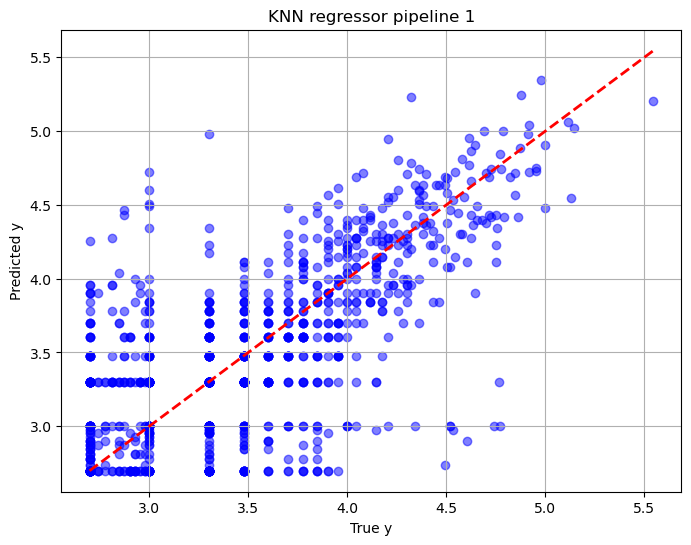

In [11]:
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(pipe1_train, y_train)
predictions = neigh.predict(pipe1_val)
MAE = mean_absolute_error(y_val, predictions)
print(f"The mean absolute error is {MAE}")

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("KNN regressor pipeline 1")
plt.grid(True)
plt.show()


The mean absolute error is 0.38805090569731615


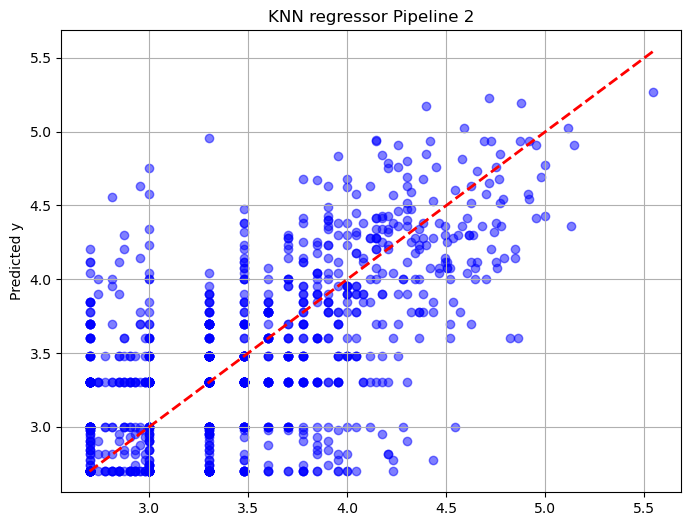

In [12]:
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(pipe2_train, y_train)
predictions = neigh.predict(pipe2_val)
MAE = mean_absolute_error(y_val, predictions)
print(f"The mean absolute error is {MAE}")

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.ylabel("Predicted y")
plt.title("KNN regressor Pipeline 2")
plt.grid(True)
plt.show()

### Linear Regressor with SGD


The mean absolute error is 0.27403274320281956


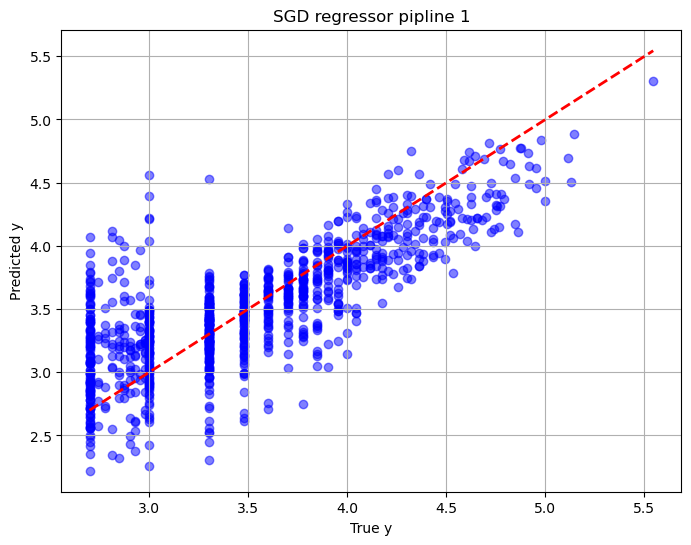

In [13]:
regressor = SGDRegressor(loss="squared_error", random_state=SEED)
regressor.fit(pipe1_train,y_train)
predictions = regressor.predict(pipe1_val)
MAE = mean_absolute_error(y_val, predictions)
print(f"The mean absolute error is {MAE}")

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("SGD regressor pipline 1")
plt.grid(True)
plt.show()

The mean absolute error is 0.30065207870154403


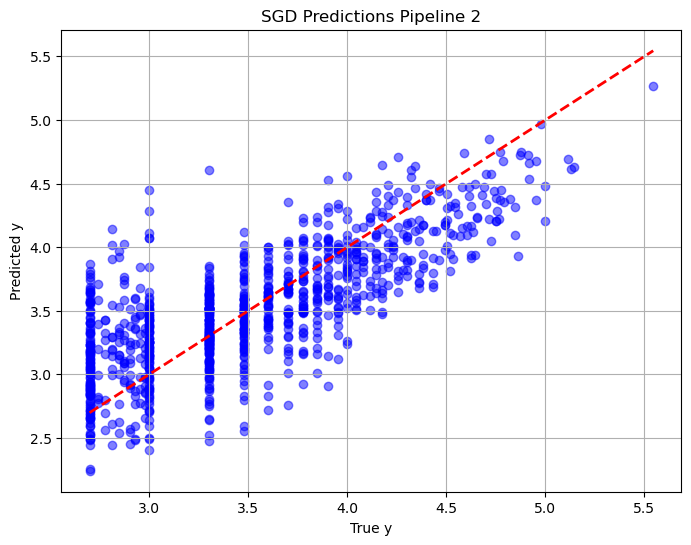

In [14]:
regressor = SGDRegressor(loss="squared_error", random_state=SEED)
regressor.fit(pipe2_train,y_train)
predictions = regressor.predict(pipe2_val)
MAE = mean_absolute_error(y_val, predictions)
print(f"The mean absolute error is {MAE}")

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("SGD Predictions Pipeline 2")
plt.grid(True)
plt.show()

# Part C
We determined pipeline 1 to be the best one and will optimize for this.
### kNN

KNN gridsearch manually to create training curve

The best parameters are {'n_neighbors': 40, 'p': 1}
The validation score of this was 0.259550343115853


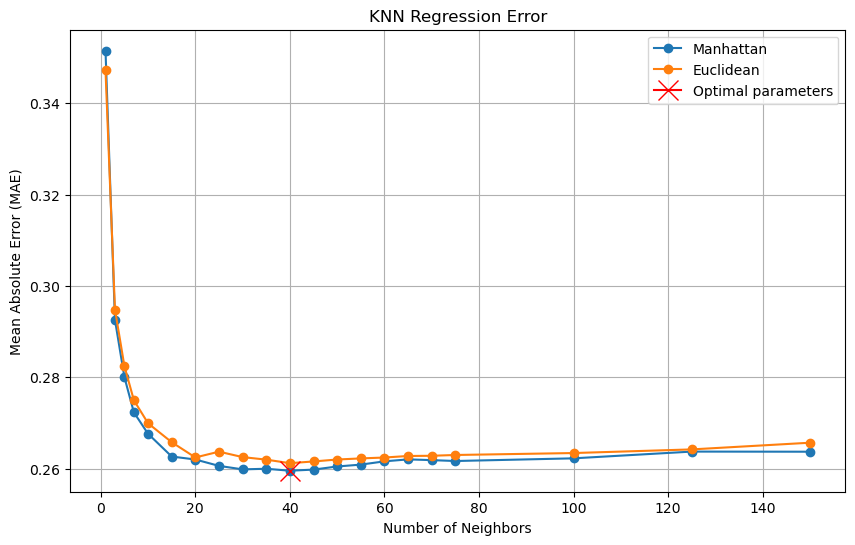

In [15]:
grid_params = {'n_neighbors': [1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,100,125,150],
        'p': [1,2]
        }
error = np.zeros((len(grid_params['p']), len(grid_params['n_neighbors'])))
lowest_error = np.inf
best_params = {'n_neighbors': None,
        'p': None
        }
for i in range(len(grid_params['n_neighbors'])):
    for j in range(len(grid_params['p'])):
        neigh = KNeighborsRegressor(n_neighbors=grid_params['n_neighbors'][i], p=grid_params['p'][j])
        neigh.fit(pipe1_train, y_train)
        predictions = neigh.predict(pipe1_val)
        MAE = mean_absolute_error(y_val, predictions)
        error[j,i] = MAE
        if MAE < lowest_error:
            lowest_error = MAE
            best_params['n_neighbors'] = grid_params['n_neighbors'][i]
            best_params['p'] = grid_params['p'][j]
print(f"The best parameters are {best_params}")
print(f"The validation score of this was {lowest_error}")

# Plotting
plt.figure(figsize=(10,6))

plt.plot(grid_params['n_neighbors'], error[0], marker='o', label='Manhattan')
plt.plot(grid_params['n_neighbors'], error[1], marker='o', label='Euclidean')
plt.plot(best_params['n_neighbors'], lowest_error, color='red', marker='x', markersize=14, label='Optimal parameters')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('KNN Regression Error')
plt.legend()
plt.grid(True)
plt.show()

kNN gridsearch using sklearn

Best cross-validation score is: 0.25936264763891503
The best hyperparameters are: {'n_neighbors': 35, 'p': 1}
The mean absolute error is 0.2599812526655145


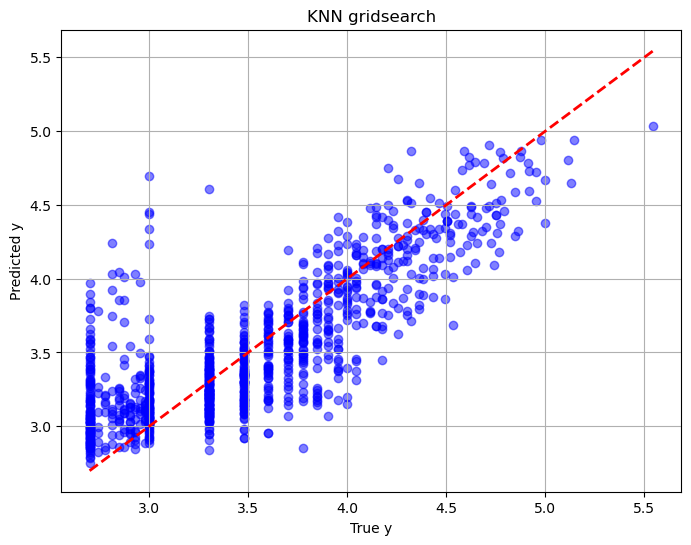

In [16]:
neigh = KNeighborsRegressor()
grid_params = {'n_neighbors': [1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75],
        'p': [1,2],
        }
gridsearch = GridSearchCV(neigh, grid_params, cv=8, scoring='neg_mean_absolute_error')
gridsearch.fit(pipe1_train, y_train)
print(f"Best cross-validation score is: {-gridsearch.best_score_}")
print(f"The best hyperparameters are: {gridsearch.best_params_}")
best_knn = gridsearch.best_estimator_
predictions = best_knn.predict(pipe1_val)
MAE = mean_absolute_error(y_val, predictions)
print(f"The mean absolute error is {MAE}")

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("KNN gridsearch")
plt.grid(True)
plt.show()

### SGD
Manually to include training curve.

The best parameters are {'penalty': 'l2', 'alpha': np.float64(0.00017575106248547893)}
The validation score of this was 0.2730491636020509


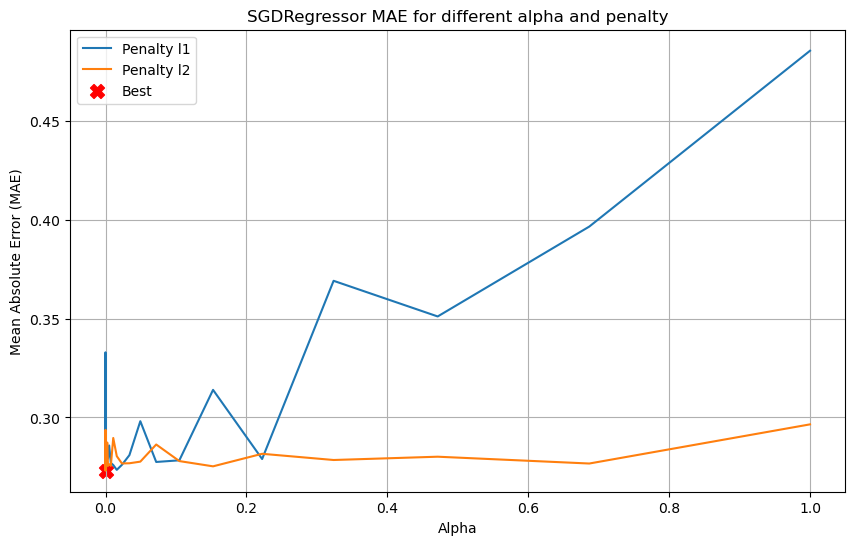

In [17]:
grid_params = {
    'penalty': ['l1', 'l2'],
    'alpha': np.logspace(-8, 0, 50),
        }
error = np.zeros(len(grid_params['alpha']) * len(grid_params['penalty']))
lowest_error = np.inf
best_params = {'penalty': None,
        'alpha': None
        }
for idx, (alph, pen) in enumerate(product(grid_params['alpha'], grid_params['penalty'])):
    regressor = SGDRegressor(loss="squared_error", penalty=pen, alpha=alph, eta0=0.1)
    regressor.fit(pipe1_train, y_train)
    predictions = regressor.predict(pipe1_val)
    MAE = mean_absolute_error(y_val, predictions)
    error[idx] = MAE
    if MAE < lowest_error:
            lowest_error = MAE
            best_params['penalty'] = pen
            best_params['alpha'] = alph

print(f"The best parameters are {best_params}")
print(f"The validation score of this was {lowest_error}")

error_matrix = error.reshape(len(grid_params['alpha']), len(grid_params['penalty']))
error_matrix

# Plotting
plt.figure(figsize=(10,6))
plt.plot(grid_params['alpha'], error_matrix[:, 0], label=f'Penalty l1')
plt.plot(grid_params['alpha'], error_matrix[:, 1], label=f'Penalty l2')
plt.scatter(best_params['alpha'], lowest_error, color='red', s=100, marker='X', label='Best')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('SGDRegressor MAE for different alpha and penalty')
plt.legend()
plt.grid(True)
plt.show()

Using Sklearn

Best cross-validation score is: 0.27747397471641666
The best hyperparameters are: {'alpha': np.float64(0.0), 'learning_rate': 'adaptive', 'penalty': 'l1'}
The mean absolute error is 0.2748378244862724


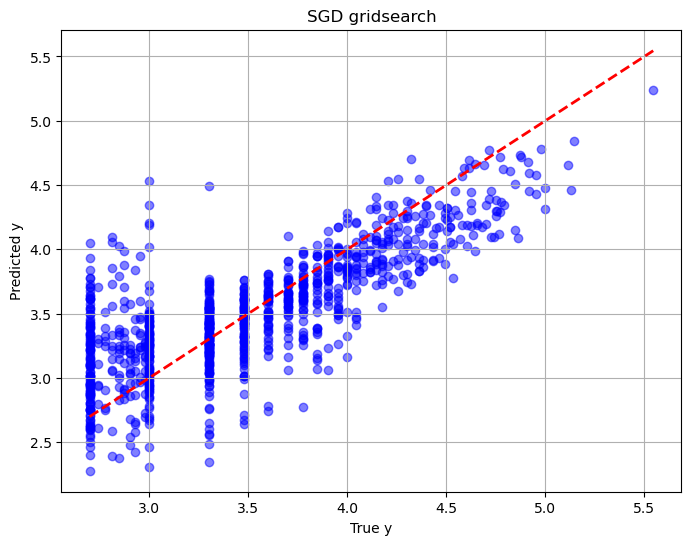

In [18]:
regressor = SGDRegressor(loss="squared_error", random_state=SEED)
grid_params = {
    'penalty': ['l1', 'l2'],
    'alpha': np.linspace(0, 1e-1, 100),
    'learning_rate': ['constant', 'adaptive'],
        }
gridsearch = GridSearchCV(regressor, grid_params, cv=8, scoring='neg_mean_absolute_error')
gridsearch.fit(pipe1_train, y_train)
print(f"Best cross-validation score is: {-gridsearch.best_score_}")
print(f"The best hyperparameters are: {gridsearch.best_params_}")
best_regressor = gridsearch.best_estimator_
predictions = best_regressor.predict(pipe1_val)
MAE = mean_absolute_error(y_val, predictions)
print(f"The mean absolute error is {MAE}")

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("SGD gridsearch")
plt.grid(True)
plt.show()

### Autograder 

In the autograder you will need to provide two things: 1) estimate of the MAE of your model on unseen data, 2) the predictions on the autograder data. For the autograder data we only provide the features and not the regression targets. Thus, you cannot compute the MAE on this data yourself - you need to estimate that with the data provided above. 

In [19]:
data_autograder = pd.read_csv('football_autograde.csv')
data_autograder.head()


,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_agility,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,27.0,190.0,78.0,b'England',70.0,71.0,52.0,42.0,75.0,60.0,...,57.0,67.0,61.0,72.0,68.0,15.0,8.0,12.0,13.0,15.0
1,19.0,183.0,76.0,b'Republic of Ireland',59.0,77.0,45.0,20.0,53.0,60.0,...,66.0,55.0,69.0,59.0,57.0,8.0,11.0,10.0,6.0,11.0
2,20.0,172.0,67.0,b'China PR',48.0,53.0,40.0,34.0,38.0,52.0,...,57.0,56.0,70.0,35.0,43.0,12.0,6.0,9.0,7.0,12.0
3,28.0,170.0,65.0,b'Brazil',76.0,76.0,73.0,76.0,52.0,72.0,...,89.0,70.0,88.0,50.0,48.0,12.0,7.0,12.0,10.0,7.0
4,28.0,186.0,74.0,b'England',65.0,67.0,18.0,19.0,15.0,25.0,...,32.0,57.0,57.0,14.0,17.0,66.0,64.0,66.0,63.0,68.0


In [20]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([0.265])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
# your predictions here should again be the $log_{10}(wage)$ of the football player, just as in the provided data.
# Load the autograder data
data_autograder = pd.read_csv('football_autograde.csv')
data_autograder = data_autograder.drop(columns="nationality_name")
# Make predictions using the best model
testX = scaler.transform(data_autograder)
testX = pd.DataFrame(data=testX, columns=labels)
testX = testX[important_features['Labels']].copy()
for col in pipe1_train.columns:
    important = important_features.loc[important_features['Labels'] == col, 'Importance Coefficient'].values[0]
    testX[col] = testX[col] * (1+important)
predictions_autograder_data = best_knn.predict(testX) 

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("wage_predictions.txt", index=False, header=False)